<a href="https://colab.research.google.com/github/vijayakuruba/IFT6390_Classification_of_AMP_sequences/blob/main/IFT_6390_Final_Project_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFT6390: Final Project

The final project pertains to the problem of finding novel [antimicrobial peptides](https://en.wikipedia.org/wiki/Antimicrobial_peptides) (AMP) which may turn out to be key in the fight against antibiotics resistance. The World Health Organization qualifies antibiotic resistance as one of the [''biggest threats to global health, food security, and development today''](https://www.who.int/news-room/fact-sheets/detail/antibiotic-resistance).

Given the limited time frame of this project, I have scoped down the problems to two main tracks:

1. **Classification**: classifying protein sequences as AMP or non-AMP: a binary classification problem
  1.1 You are allowed to use Scikit-learn. You need to provide the following baselines: Random Forest, SVM, Neural Network. Use TF-IDF as a baseline feature extractor (you can use sklearn) for each of those.  
2. **Generation**: Given a corpus of AMP sequences, learn a character-level language model. You should implement a baseline using a Markov model. Then implement a sequential model using an RNN or LSTM. 

You should pick one of the two options. Choose your own adventure. You can work in teams of **three people max**.

# Dataset

The dataset in this project comes from two open source projects: amPEPpy and AMPlify.

In [ ]:
!pip install biopython
!wget https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/AMP_20190407.fa
!wget https://raw.githubusercontent.com/bcgsc/AMPlify/master/data/non_AMP_20190413.fa
!wget https://raw.githubusercontent.com/tlawrence3/amPEPpy/master/training_data/M_model_train_AMP_sequence.numbered.fasta
!wget https://raw.githubusercontent.com/tlawrence3/amPEPpy/master/training_data/M_model_train_nonAMP_sequence.numbered.fasta

In [ ]:
from Bio import SeqIO
import matplotlib.pyplot as plt

In [ ]:
def fasta_to_str_set(name):
  return {str(rec.seq) for rec in SeqIO.parse(name, 'fasta')}

In [ ]:
positive_examples = fasta_to_str_set('AMP_20190407.fa').union(fasta_to_str_set('M_model_train_AMP_sequence.numbered.fasta'))
negative_examples = fasta_to_str_set('non_AMP_20190413.fa').union(fasta_to_str_set('M_model_train_nonAMP_sequence.numbered.fasta'))

Once we have merged the two data sources, the positive class has:

In [ ]:
print(f"{len(positive_examples)} examples")

5264 examples


and the negative class (non-AMPs) has:

In [ ]:
print(f"{len(negative_examples)} examples")

167732 examples


Let's have a look at the data. For example, the first AMP and Non AMP in the dataset is:

In [ ]:
print('First AMP sample is : ',list(positive_examples)[0])
print('First Non AMP sample is :',list(negative_examples)[0])

First AMP sample is :  FLPIVGRLISGLL
First Non AMP sample is : MPARFDCFVTGTDTEIGKTLVSAVLLTRLADAGYRAAGLKPIAAGTLAGAPTRTNEDVEQLRAAASVNLPFDTVCPWLLDAPMSPHLAAAREGVTITLPPILDAFAHARSLADAVVVEGVGGFRVPLSDDFDTAEMAVALGLPVVLVVGLRLGCLNHAALTAEAIAARGLHLAGWVGNVVDPSMAGLDDNVATLRRWINAPHLGTIPRLPHADARLAAAHVDIAPLLARTAETRR


We have 2 challenges here:
1. Imbalanced dataset: No of non-AMPs are more way higher than AMP. 
2. the distribution of the sequence lengths varies a lot between the two classes. 

## Exploratory data Analysis

Text(0.5, 1.0, 'Negative Sequence Lengths')

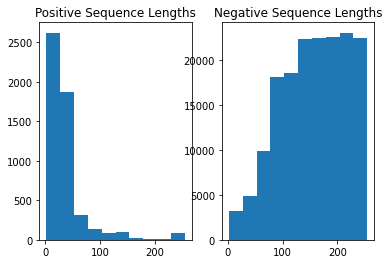

In [ ]:
# Visualise samples

#Original dataset

fig, axes = plt.subplots(1,2)
axes[0].hist([len(seq) for seq in positive_examples])
axes[0].set_title('Positive Sequence Lengths')
axes[1].hist([len(seq) for seq in negative_examples])
axes[1].set_title('Negative Sequence Lengths')

## Feature importance
Lets see which Amino acid is more important. We have used TFIDI Tokenizor to count the raw frequencies and plotted the features which are more frequent or Important

In [ ]:
#TFIDI Tokenizor: This function will be used downstream

def dummy(doc):
    return doc
tfidf = TfidfVectorizer(tokenizer=dummy,preprocessor=dummy,lowercase=False)  

In [ ]:
# create Datarame with original dataset

# Dataframe with original data

import pandas as pd 
df_orig_p=pd.DataFrame(positive_examples,columns=['Sequences'])
df_orig_p['Labels']=1
df_orig_n=pd.DataFrame(negative_examples,columns=['Sequences'])
df_orig_n['Labels']=0

df=pd.DataFrame()
df=df.append(df_orig_p,ignore_index=True)
df=df.append(df_orig_n,ignore_index=True)
print(df.shape)
df

This string describes the sequence of amino acids present in the given AMP. There are  20  possible such standard amino acids present in the genetic code. 
We can see from the plot below that the most frequent amino acid code is Leucine(L) followed by Alanine(A), Valine(V) and Glycine(G).

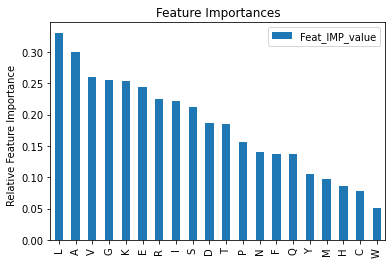

In [ ]:
#TfidfVectorizer

import numpy as np

X=df['Sequences']

X_transform = tfidf.fit_transform(X)
word = tfidf.get_feature_names()

TFIDF_mean = np.mean(X_transform, axis=0)

TFIDF_mean = np.array(TFIDF_mean)[0].tolist()

# Feature_importance=top_feats(TFIDF_mean ,Word, Imp_Feat)

topn_ids = np.argsort(TFIDF_mean)[::-1][:1000]
names = np.array(word)
# print(names[topn_ids])
top_feats = [(word[i], TFIDF_mean[i]) for i in topn_ids]
df_feat = pd.DataFrame(top_feats, index=names[topn_ids])
df_feat.columns = ['FEATURE', 'Feat_IMP_value']

Feature_importance = df_feat
df_feat[:30].plot.bar(y='Feat_IMP_value', title='Feature Importances', rot=90)
plt.ylabel('Relative Feature Importance  ')
New_FI_index = Feature_importance.reset_index()
del New_FI_index['index']
plt.show()
#plt.savefig('feature_Importance.png')

#Construct Non AMP Dataset

To addres the issue of the the distribution of the sequence lengths  between the two classes, I have reconstructed non AMP dats such that, I have included only the sequences whose legths are present in AMP sequence. For example samples whose sequence length is 145 is discared since this length is not present in AMP sequence. 
After this , Non AMP samples are reduced to 109344. 

Even after this still we have imbalanced dataset issue which will be addressed with Oversampling and Undersampling techniques.

First construct Non AMP samples:

In [ ]:
import numpy as np

lenp=[]
for seq in positive_examples:
    lenp.append(len(seq))
ulenp=np.unique(lenp)
print(ulenp)

[  2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108 109 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 133 134 135 136 137 138 140 141 142 143 146 148 149 150 152 153 154
 155 157 158 161 163 164 166 169 172 174 177 183 185 187 188 190 191 192
 194 198 200 201 204 206 207 208 215 219 220 221 222 225 226 230 231 235
 239 241 243 244 245 247 255]


In [ ]:
lenn=[]
for seq in negative_examples:
    lenn.append(len(seq))
print(np.unique(lenn))

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 24

In [ ]:
negative_examples_new=[]
for i in ulenp:
    for seq in negative_examples: 
        if len(seq)==i:
           negative_examples_new.append(seq)

print(len(negative_examples_new))

109344


Lets visualise the samples after reconstructing the negative samples
Still we have imbalanced data issue

Text(0.5, 1.0, 'Negative Sequence Lengths')

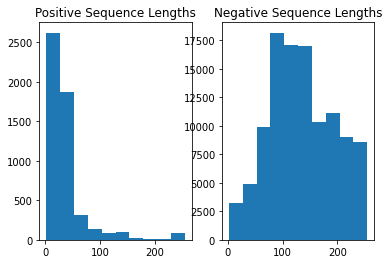

In [ ]:
# after removing sequences in Non AMP whose length is not in postivie sample 

fig, axes = plt.subplots(1,2)
axes[0].hist([len(seq) for seq in positive_examples])
axes[0].set_title('Positive Sequence Lengths')
axes[1].hist([len(seq) for seq in negative_examples_new])
axes[1].set_title('Negative Sequence Lengths')

In [ ]:
df_recon_n=pd.DataFrame(negative_examples_new,columns=['Sequences'])
df_recon_n['Labels']=0

In [ ]:
print('positive_examples shape is:', df_orig_p.shape)
print('Original negative_examples shape is:', df_orig_n.shape)
print('Reconstructed negative_examples shape is:', df_recon_n.shape)

positive_examples shape is: (5264, 2)
Original negative_examples shape is: (167732, 2)
Reconstructed negative_examples shape is: (109344, 2)


In [ ]:
# dataframe with new datset
df_new=pd.DataFrame()
df_new=df_new.append(df_orig_p,ignore_index=True)
df_new=df_new.append(df_recon_n,ignore_index=True)
print(df_new.shape)
df_new

(114608, 2)


,Sequences,Labels
0,FLPIVGRLISGLL,1
1,APQMKTRDVLERTHKCFLVGGECKSECSSWEYEYVFCYTGPCCVMR...,1
2,KRGLWESLKRKATKLGDDIRNTLRNFKIKFPVPRQG,1
3,TNYGNGVGVPDAIMAGIIKLIFIFNIRQGYNFGKKAT,1
4,RADTQTYQPYNKDWIKEKIYVLLRRQAQQAGK,1
...,...,...
114603,MRHPLVMGNWKLNGSTHMVNELIANLRKELSTVEGCGVAIAPPAIY...,0
114604,MPRYKLTIEYDGGPFCGWQYQTNGPSVQGALEAAVKAICGDDVRVH...,0
114605,MEMVDSCHFSPSEFFYDSSCIPSPEEGYTEDYEHGMSIYGAHKKDL...,0
114606,MFNLFPPFGANTAIFNDAPQPWQVGFQDGASPTQEGITELHDSIFF...,0


#Data Preprocessing

Issue of Imbalance data is addressed with Oversampling and undersample techniques

Imbalanced data is managed with Random oversampling from imblearn, which oversamples the minority class

In [ ]:
X = df_new['Sequences']
y=  df_new['Labels'] 


In [ ]:
X = X.values.reshape(-1,1)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

os =  RandomOverSampler(sampling_strategy='minority')
X_res, y_res = os.fit_sample(X , y)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_res.shape,y_res.shape

((218688, 1), (218688,))

In [ ]:
from collections import Counter

print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 109344, 1: 5264})
Resampled dataset shape Counter({1: 109344, 0: 109344})


In [ ]:
dftrain=pd.DataFrame(X_res)
dftrain.columns =['Sequences']
dftrain['Labels']=y_res

In [ ]:
dftrain

,Sequences,Labels
0,FLPIVGRLISGLL,1
1,APQMKTRDVLERTHKCFLVGGECKSECSSWEYEYVFCYTGPCCVMR...,1
2,KRGLWESLKRKATKLGDDIRNTLRNFKIKFPVPRQG,1
3,TNYGNGVGVPDAIMAGIIKLIFIFNIRQGYNFGKKAT,1
4,RADTQTYQPYNKDWIKEKIYVLLRRQAQQAGK,1
...,...,...
218683,IMGPVLGLVSNALGGLLKNL,1
218684,FFHHIFRGIVHVGKTIHRLVTG,1
218685,IIGHLIKTALGFLGL,1
218686,FFPTIAGLTKLFCAITKKC,1


Visualize the new oversampled data

In [ ]:
#positive_examples=dftrain.query['Labels'==1]

options = [1]  
    
# selecting rows based on condition  
datap = dftrain[dftrain['Labels'].isin(options)]  
positive_examples=datap['Sequences']

In [ ]:
positive_examples

0                                             FLPIVGRLISGLL
1         APQMKTRDVLERTHKCFLVGGECKSECSSWEYEYVFCYTGPCCVMR...
2                      KRGLWESLKRKATKLGDDIRNTLRNFKIKFPVPRQG
3                     TNYGNGVGVPDAIMAGIIKLIFIFNIRQGYNFGKKAT
4                          RADTQTYQPYNKDWIKEKIYVLLRRQAQQAGK
                                ...                        
218683                                 IMGPVLGLVSNALGGLLKNL
218684                               FFHHIFRGIVHVGKTIHRLVTG
218685                                      IIGHLIKTALGFLGL
218686                                  FFPTIAGLTKLFCAITKKC
218687                                        PKRKSATKGDEPA
Name: Sequences, Length: 109344, dtype: object

In [ ]:
#positive_examples=dftrain.query['Labels'==1]

options = [0]  
    
# selecting rows based on condition  
datan = dftrain[dftrain['Labels'].isin(options)]  
negative_examples=datan['Sequences']

In [ ]:
negative_examples

5264                                                     GW
5265                                                   LWSG
5266                                                   YMRF
5267                                                   FLRF
5268                                                   GSWD
                                ...                        
114603    MRHPLVMGNWKLNGSTHMVNELIANLRKELSTVEGCGVAIAPPAIY...
114604    MPRYKLTIEYDGGPFCGWQYQTNGPSVQGALEAAVKAICGDDVRVH...
114605    MEMVDSCHFSPSEFFYDSSCIPSPEEGYTEDYEHGMSIYGAHKKDL...
114606    MFNLFPPFGANTAIFNDAPQPWQVGFQDGASPTQEGITELHDSIFF...
114607    MSMPFYVSPEQLMKDRADYARKGIARGRSVVVAAYDGGIAFATENP...
Name: Sequences, Length: 109344, dtype: object

Text(0.5, 1.0, 'Negative Sequence Lengths')

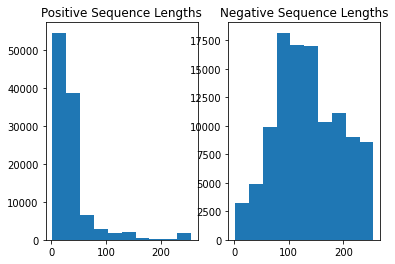

In [ ]:

fig, axes = plt.subplots(1,2)
axes[0].hist([len(seq) for seq in positive_examples])
axes[0].set_title('Positive Sequence Lengths')
axes[1].hist([len(seq) for seq in negative_examples])
axes[1].set_title('Negative Sequence Lengths')

Here I am using Undersampling techniques with Random undersampling from imblearn, which undersamples the majority class

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

os =  RandomUnderSampler(sampling_strategy='majority')
X_res_u, y_res_u = os.fit_sample(X , y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res_u)))

Original dataset shape Counter({0: 109344, 1: 5264})
Resampled dataset shape Counter({0: 5264, 1: 5264})


In [ ]:
dftrain_u=pd.DataFrame(X_res_u)
dftrain_u.columns =['Sequences']
dftrain_u['Labels']=y_res_u

Visualize the new oversampled data

Text(0.5, 1.0, 'Negative Sequence Lengths')

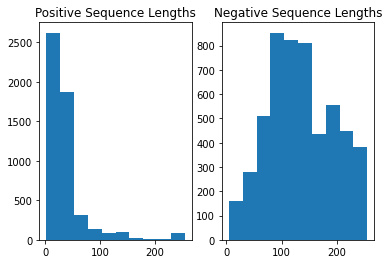

In [ ]:
#positive_examples=dftrain.query['Labels'==1]
 
datapu = dftrain_u[dftrain_u['Labels'].isin([1])]  
positive_examples=datapu['Sequences']
 
datanu = dftrain_u[dftrain_u['Labels'].isin([0])]  
negative_examples=datanu['Sequences']

fig, axes = plt.subplots(1,2)
axes[0].hist([len(seq) for seq in positive_examples])
axes[0].set_title('Positive Sequence Lengths')
axes[1].hist([len(seq) for seq in negative_examples])
axes[1].set_title('Negative Sequence Lengths')

#Tokenize Charecters

Tokenize the sequence in to chanrecters

In [ ]:
# pre processing data
def cleanData(sentence):
    processedList = ""
    
# Tokenize sequence to charecters
    sentence=list(sentence)
  
    return sentence

In [ ]:

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix,roc_auc_score,f1_score
from sklearn.svm import SVC


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

#Intitialisation

In [ ]:
# Havent used yet
result = pd.DataFrame(columns = ("classifers","Training","Testing"))
classifier, train_scores, test_scores = [],[],[]

#Cross validation 

In [ ]:
#Cross validation with K fold=5
k_fold = KFold(n_splits=5, shuffle=True,random_state=1)

#Baselines

Random Forest :  Random forests (Breiman, 2001) is a substantial modification of bagging that builds a large collection of de-correlated trees, and then averages them. Random Forest = Bagging of trees+Random feature selection 

1. Each decision tree is trained using a slightly different version of the training set, using both by

*   Bootstrapping (random selection of examples, withreplacement)
*   Randomly selecting a subset of features (reduce the inputdimension)

2.	The capacity of each tree (i.e. depth) is chosen using cross validation.

3.	The final prediction is a majority vote, like in Bagging

Algorithim:
1. For b = 1 to B:\
(a) Draw a bootstrap sample Z∗ of size N from the training data.\
(b) Grow a random-forest tree ${T_b}$ to the bootstrapped data, by recursively repeating the following steps for each terminal node of
the tree, until the minimum node size ${n_{min}}$ is reached.\
i. Select m variables at random from the p variables.\
ii. Pick the best variable/split-point among the m.\
iii. Split the node into two daughter nodes.
2. Output the ensemble of trees {${T_b}^B_1$} .\
To make a prediction at a new point x:\
Classification: Let $C_b(x)$ be the class prediction of the bth random-forest
tree. Then $C^B_{rf} (x) = majority vote$ $[{C^b(x)}]^B_1$  .



##Random Forest Classifier with oversampling data

In [ ]:
# tokenize charecters
dftrain['Sequences']  = dftrain['Sequences'] .map(lambda x: cleanData(x))
dftrain['Sequences']

0                   [F, L, P, I, V, G, R, L, I, S, G, L, L]
1         [A, P, Q, M, K, T, R, D, V, L, E, R, T, H, K, ...
2         [K, R, G, L, W, E, S, L, K, R, K, A, T, K, L, ...
3         [T, N, Y, G, N, G, V, G, V, P, D, A, I, M, A, ...
4         [R, A, D, T, Q, T, Y, Q, P, Y, N, K, D, W, I, ...
                                ...                        
218683    [I, M, G, P, V, L, G, L, V, S, N, A, L, G, G, ...
218684    [F, F, H, H, I, F, R, G, I, V, H, V, G, K, T, ...
218685        [I, I, G, H, L, I, K, T, A, L, G, F, L, G, L]
218686    [F, F, P, T, I, A, G, L, T, K, L, F, C, A, I, ...
218687              [P, K, R, K, S, A, T, K, G, D, E, P, A]
Name: Sequences, Length: 218688, dtype: object

In [ ]:
rfs = RandomForestClassifier()

In [ ]:
X_rs=dftrain['Sequences'] 
y_rs=dftrain['Labels'] 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, stratify=y_rs, 
    test_size=0.2, shuffle=True)

In [ ]:
#TFIDI Tokenizor

def dummy(doc):
    return doc
tfidf = TfidfVectorizer(tokenizer=dummy,preprocessor=dummy,lowercase=False)    

In [ ]:
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

rfs.fit(X_train,y_train)
y_pred = rfs.predict(X_test)
accuracy_score(y_test, y_pred)

0.992363619735699

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     21869
           1       0.98      1.00      0.99     21869

    accuracy                           0.99     43738
   macro avg       0.99      0.99      0.99     43738
weighted avg       0.99      0.99      0.99     43738



As we can see , Definetly model is overfitting data

In [ ]:
scores = cross_validate(clf_rf1, X_rs, y_rs, scoring=['accuracy','f1','precision','roc_auc'], cv=k_fold, return_train_score=True)

In [ ]:
print("Reg: Test Accuracy: %0.4f (+/- %0.4f)" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()))
print("Reg: Test f1 score: %0.4f (+/- %0.4f)" % (scores['test_f1'].mean(), scores['test_f1'].std()))
print("Reg: Test precision: %0.4f (+/- %0.4f)" % (scores['test_precision'].mean(), scores['test_precision'].std()))
print("Reg: Test roc_auc: %0.4f (+/- %0.4f)" % (scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))

Reg: Test Accuracy: 0.9928 (+/- 0.0003)
Reg: Test f1 score: 0.9929 (+/- 0.0003)
Reg: Test precision: 0.9859 (+/- 0.0006)
Reg: Test roc_auc: 0.9953 (+/- 0.0002)


##Random Forest Classifier with Undersampling data

In [ ]:
# tokenize charecters
dftrain_u['Sequences']  = dftrain_u['Sequences'] .map(lambda x: cleanData(x))
dftrain_u['Sequences']

0        [M, R, T, E, Q, L, T, A, K, A, M, E, K, V, N, ...
1        [M, A, A, A, Q, V, K, N, E, K, I, G, N, P, K, ...
2        [M, K, N, L, I, K, N, K, I, K, L, S, T, Y, N, ...
3        [M, I, R, R, R, K, K, V, R, K, L, R, G, S, H, ...
4        [M, A, I, L, A, K, A, V, G, R, R, K, E, A, V, ...
                               ...                        
10523    [G, L, W, S, K, I, K, E, V, G, K, E, A, A, K, ...
10524    [V, L, E, V, Y, Y, T, S, L, R, C, R, C, V, Q, ...
10525                 [G, I, H, R, I, L, K, Y, G, K, P, S]
10526    [K, L, G, I, D, V, S, Q, P, T, S, T, S, S, F, ...
10527                       [G, G, G, G, G, G, H, L, V, A]
Name: Sequences, Length: 10528, dtype: object

In [ ]:
X_rsu=dftrain_u['Sequences'] 
y_rsu=dftrain_u['Labels'] 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_rsu, y_rsu, stratify=y_rsu, 
    test_size=0.2, shuffle=True)

In [ ]:
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

rfs.fit(X_train,y_train)
y_pred = rfs.predict(X_test)
accuracy_score(y_test, y_pred)

0.9344729344729344

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1053
           1       0.93      0.94      0.94      1053

    accuracy                           0.93      2106
   macro avg       0.93      0.93      0.93      2106
weighted avg       0.93      0.93      0.93      2106



Since the data is less, I would like to see the effects of hyperparameters

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_rsu, y_rsu, stratify=y_rsu, 
    test_size=0.2, shuffle=True)


parameters = {
  'model__max_depth': [None,10,20,50],
  'model__n_estimators':[100,500,1000,1500,2000]
  }

pipeline = Pipeline([('tfidf', tfidf),('model',rfs)])

grid = GridSearchCV(pipeline, cv=k_fold, n_jobs=-1, param_grid=parameters)
grid.fit(X_train, y_train)
print('finished')



finished


In [ ]:
#to try with few more parameters, Not tried
parameters = {
  'model__n_estimators':[100,500,1000,1500,3500],
  'model__max_features': ['auto', 'sqrt', 'log2'],
  'model__min_samples_split': [2,5,10,15,20],
  'model__max_depth': [None,10,20,30,40,50],
  'model__min_samples_leaf' : [1,2,5,10,15]
  }

In [ ]:
print("Best parameters set found on development set:")
print()
print(grid.best_params_)

Best parameters set found on development set:

{'model__max_depth': None, 'model__n_estimators': 500}


In [ ]:
print("Grid scores on development set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Grid scores on development set:

0.936 (+/-0.013) for {'model__max_depth': None, 'model__n_estimators': 100}
0.936 (+/-0.010) for {'model__max_depth': None, 'model__n_estimators': 500}
0.936 (+/-0.011) for {'model__max_depth': None, 'model__n_estimators': 1000}
0.936 (+/-0.012) for {'model__max_depth': None, 'model__n_estimators': 1500}
0.935 (+/-0.011) for {'model__max_depth': None, 'model__n_estimators': 2000}
0.932 (+/-0.010) for {'model__max_depth': 10, 'model__n_estimators': 100}
0.931 (+/-0.011) for {'model__max_depth': 10, 'model__n_estimators': 500}
0.931 (+/-0.008) for {'model__max_depth': 10, 'model__n_estimators': 1000}
0.931 (+/-0.010) for {'model__max_depth': 10, 'model__n_estimators': 1500}
0.930 (+/-0.010) for {'model__max_depth': 10, 'model__n_estimators': 2000}
0.935 (+/-0.014) for {'model__max_depth': 20, 'model__n_estimators': 100}
0.935 (+/-0.011) for {'model__max_depth': 20, 'model__n_estimators': 500}
0.935 (+/-0.011) for {'model__max_depth': 20, 'model__n_estimat

In [ ]:
classification_report(grid.best_estimator_.predict(X_test), y_test)


'              precision    recall  f1-score   support\n\n           0       0.92      0.94      0.93      1033\n           1       0.94      0.93      0.94      1073\n\n    accuracy                           0.93      2106\n   macro avg       0.93      0.93      0.93      2106\nweighted avg       0.93      0.93      0.93      2106\n'

##SMOTE
This is another Technnique in oversampling :  we can try later
This has to be done after transform data

In [ ]:
# tokenize charecters
df['Sequences']  = df['Sequences'] .map(lambda x: cleanData(x))0

0         [R, T, C, E, N, L, A, D, K, Y, R, G, P, C, F, ...
1         [V, F, G, T, L, G, S, T, D, D, S, L, F, G, R, ...
2         [G, I, F, S, K, K, A, G, K, G, F, K, K, K, S, ...
3         [R, I, G, S, F, L, G, A, L, A, S, K, L, P, T, ...
4                      [G, I, H, D, I, L, K, Y, G, K, P, A]
                                ...                        
114603    [M, E, K, C, E, G, I, V, I, R, Q, T, S, Y, R, ...
114604    [M, D, R, L, V, I, G, G, R, E, L, K, N, R, L, ...
114605    [M, K, V, K, V, F, D, L, N, G, Q, P, V, D, E, ...
114606    [M, S, T, N, L, H, W, Q, S, F, G, Q, G, P, D, ...
114607    [M, Q, L, T, N, K, K, I, V, V, T, G, V, S, S, ...
Name: Sequences, Length: 114608, dtype: object

In [ ]:
#TfidfVectorizer

X_s=df['Sequences'] 
y_s=df['Labels'] 

x_transform_s,word_s = tfdi(X_s)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [ ]:
# Imbalance data with SMOTE
from imblearn.over_sampling import SMOTE

sm =  SMOTE(sampling_strategy='minority')
X_res_s, y_res_s = sm.fit_sample(x_transform_s , y_s)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print('Original dataset shape {}'.format(Counter(y_s)))
print('Resampled dataset shape {}'.format(Counter(y_res_s)))

Original dataset shape Counter({0: 109344, 1: 5264})
Resampled dataset shape Counter({1: 109344, 0: 109344})


In [ ]:
# SMOTE data

X_train, X_test, y_train, y_test = train_test_split(X_res_s, y_res_s,
    stratify=y_res_s, 
    test_size=0.2, shuffle=True)

In [ ]:
rfs = RandomForestClassifier()
rfs.fit(X_train,y_train)
y_pred = rfs.predict(X_test)
accuracy_score(y_test, y_pred)

0.9807718688554575

In [ ]:
from sklearn.metrics import scorer, accuracy_score, f1_score, confusion_matrix, roc_auc_score
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))

ROCAUC score: 0.9807718688554574
Accuracy score: 0.9807718688554575
F1 score: 0.980823167255729


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     21869
           1       0.98      0.98      0.98     21869

    accuracy                           0.98     43738
   macro avg       0.98      0.98      0.98     43738
weighted avg       0.98      0.98      0.98     43738



##SVM classifier

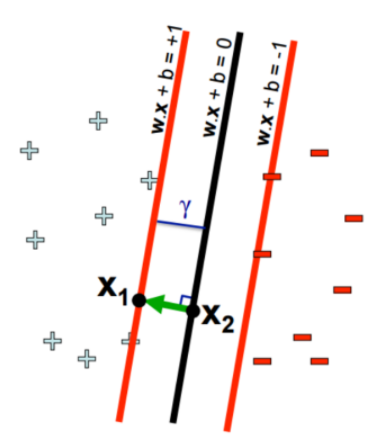

SVM algorithm learns a simple linear discriminant function g(x) =(w, x)+ b

• Finds a hyperplane, with geometric motivation of aim for maximum margin.

• It is very popular method in its lienar and Nonlinear form. Nonlinear version uses the kernel trick.

Linear Model:
\begin{equation}
 f(x) = \mathbf{w}^T \mathbf{x} + b   
\end{equation}
On Hyper plane :
\begin{equation}
f(x) =\mathbf{w}^T \mathbf{x} + b=0    
\end{equation}
Constraints are:
\begin{equation}
 \mathbf{w}^T \mathbf{x_i} + b\geq 1 \quad \text{if} \quad y_i=1 
 \end{equation}
\begin{equation}
 \mathbf{w}^T \mathbf{x_i} + b\leq -1 \quad \text{if} \quad y_i=-1   
\end{equation}

In general 
\begin{equation}
    y_i(\mathbf{w}^T \mathbf{x_i} + b)\geq 1 \quad \forall \quad i \in 1...N 
\end{equation}

Let $x_1$ be the point on boundary and $x_2$ be  the projection on hyperplane
\begin{equation}
     \mathbf{x_1-x_2} =\gamma  \frac{\mathbf{w}}{\| \mathbf{w}\|} 
\end{equation}




### Penalized SVM

 Penalize Algorithms (Cost-Sensitive Training)
The tactic is to use penalized learning algorithms that increase the cost of classification mistakes on the minority class.

A popular algorithm for this technique is Penalized-SVM.

During training, we can use the argument class_weight=’balanced’ to penalize mistakes on the minority class by an amount proportional to how under-represented it is.

We also want to include the argument probability=True if we want to enable probability estimates for SVM algorithms.

Let’s train a model using Penalized-SVM on the **original imbalanced dataset**:

In [ ]:
#Take dataframe with original dataset

# tokenize charecters
df['Sequences']  = df['Sequences'] .map(lambda x: cleanData(x))
print(df['Sequences'].shape)
df['Sequences']

(172996,)


0                   [F, L, P, I, V, G, R, L, I, S, G, L, L]
1         [A, P, Q, M, K, T, R, D, V, L, E, R, T, H, K, ...
2         [K, R, G, L, W, E, S, L, K, R, K, A, T, K, L, ...
3         [T, N, Y, G, N, G, V, G, V, P, D, A, I, M, A, ...
4         [R, A, D, T, Q, T, Y, Q, P, Y, N, K, D, W, I, ...
                                ...                        
172991    [M, H, E, M, S, I, A, E, G, I, V, Q, L, L, E, ...
172992    [M, A, P, K, K, K, E, V, T, R, I, A, K, L, N, ...
172993    [M, P, L, D, V, A, L, K, K, K, Y, Y, D, E, V, ...
172994    [M, I, G, L, N, H, Y, L, I, V, S, G, L, L, F, ...
172995    [M, E, L, K, L, S, N, E, K, G, E, A, A, G, Q, ...
Name: Sequences, Length: 172996, dtype: object

In [ ]:
X=df['Sequences']
y=df['Labels'] 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, 
    test_size=0.2, shuffle=True)

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [ ]:
#SVM
svc=SVC(random_state=0, tol=1e-5,class_weight='balanced', probability=True)


In [ ]:
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

0.9722543352601156

We can see that positive samples F1 score is 67% only.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     33547
           1       0.53      0.91      0.67      1053

    accuracy                           0.97     34600
   macro avg       0.76      0.94      0.83     34600
weighted avg       0.98      0.97      0.98     34600



In [ ]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred ))
print('Accuracy score:',accuracy_score(y_test, y_pred ))
print('F1 score:',f1_score(y_test, y_pred ))
print(confusion_matrix(y_test, y_pred))

ROCAUC score: 0.9410785695600036
Accuracy score: 0.9722543352601156
F1 score: 0.6657381615598886
[[32684   863]
 [   97   956]]


SVM module is taking 1hr to execute, So we dicided to use Linear SVC where the kernel is linear, but it is much faster than svm model.

In [ ]:
#Linear SVC

svlc=LinearSVC(random_state=0, tol=1e-5,class_weight='balanced')
svlc.fit(X_train,y_train)
y_pred = svlc.predict(X_test)
print(classification_report(y_test, y_pred))
print('ROCAUC score:',roc_auc_score(y_test, y_pred ))
print('Accuracy score:',accuracy_score(y_test, y_pred ))
print('F1 score:',f1_score(y_test, y_pred ))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     33547
           1       0.28      0.90      0.43      1053

    accuracy                           0.93     34600
   macro avg       0.64      0.91      0.69     34600
weighted avg       0.97      0.93      0.94     34600

ROCAUC score: 0.911965653437817
Accuracy score: 0.9265028901734104
F1 score: 0.4260889189799142
[[31113  2434]
 [  109   944]]


###Tune parameters

In [ ]:
X=df['Sequences']
y=df['Labels'] 

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, 
    test_size=0.2, shuffle=True)

parameters = {
  'model__C':[0.1,1,10,100]
  }

pipeline = Pipeline([('tfidf', tfidf),('model',svlc)])

grid = GridSearchCV(pipeline, cv=k_fold, n_jobs=-1, param_grid=parameters)
grid.fit(X_train, y_train)
print('finished')

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


finished


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
print("Best parameters set found on development set:")
print()
print(grid.best_params_)

Best parameters set found on development set:

{'model__C': 100}


In [ ]:
print("Grid scores on development set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Grid scores on development set:

0.927 (+/-0.004) for {'model__C': 0.1}
0.927 (+/-0.003) for {'model__C': 1}
0.931 (+/-0.004) for {'model__C': 10}
0.964 (+/-0.005) for {'model__C': 100}


In [ ]:
y_pred=grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     33547
           1       0.45      0.75      0.56      1053

    accuracy                           0.96     34600
   macro avg       0.72      0.86      0.77     34600
weighted avg       0.98      0.96      0.97     34600

[[32562   985]
 [  261   792]]


We can see that scores have been improved with hyperparameter tuning

##Neural Network

In [ ]:
#implement

from sklearn.neural_network import MLPClassifier

Nnw=MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1)#Adam


In [ ]:
Nnw.fit(X_train,y_train)
y_pred = Nnw.predict(X_test)
accuracy_score(y_test, y_pred)

0.9285289679454937

###Tune parameters

In [ ]:
#to do Hyper parameter search using Grid search

### Final Neural Network Model

In [ ]:
# implement with best Hyperparameters and calculate score

In [ ]:
y_pred = Nnw.predict(X_test)
print("Test accuracy",Nnw.score(X_test, y_test))
print("Train accuracy",Nnw.score(X_train, y_train))

classifier.append("NNW")
train_scores.append(Nnw.score(X_train, y_train))
test_scores.append(Nnw.score(X_test, y_test))

# Improvements : Ensemble method with Crossvalidation

In [ ]:
##### Trying to improve with the ensemble of all predictors
from sklearn.ensemble import VotingRegressor

Reg_vote = VotingRegressor(
    estimators=[
        ('rfs', rfs), # Random Forest
        ('svc', svc), # SVC
        ('Nn', Nnw), # Neural Network
          ])
Reg_vote.fit(X_train, y_train)
Reg_vote.score(X_val, y_val)

In [ ]:
scores = cross_val_score(Reg_vote, X_train, y_train, cv=k_fold)
print("Reg: Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))